# 2 — LSTM (Texto secuencial, word-level) con IMDB
**Portfolio ML — Ejercicio LSTM (secuencias)**  

In [7]:
import os, sys, pathlib, numpy as np
from sklearn.metrics import f1_score, accuracy_score
sys.path.append('../src')  
from utils import save_training_results, save_summary_csv, plot_training_history, plot_confusion_matrix
from lstm_data import IMDBData
from lstm_train import TextTrainer, TrainConfig
import importlib, lstm_models
importlib.reload(lstm_models)
from lstm_models import create_lstm_text_model


NOTEBOOK_NAME = "2_lstm_text_imdb"
MODEL_NAME = "lstm_imdb_tuned"
os.makedirs("results", exist_ok=True)

## 1) Carga y preparación de los datos (IMDB)

In [8]:

data = IMDBData(num_words=20000, maxlen=256, random_state=42)

(x_tr, y_tr), (x_val, y_val), (x_test, y_test) = data.load_data_with_val(val_size=0.2)

print("x_tr:", x_tr.shape, "x_val:", x_val.shape, "x_test:", x_test.shape)
print("Clases:", data.get_class_names())



x_tr: (20000, 256) x_val: (5000, 256) x_test: (25000, 256)
Clases: ['negativo', 'positivo']


## 2) Definición del modelo LSTM

In [9]:
model = create_lstm_text_model(
    vocab_size=data.vocab_size(),
    maxlen=256,
    embed_dim=128,
    lstm_units=96,
    bidirectional=True,
    dropout=0.5,
    recurrent_dropout=0.25,
    spatial_dropout=0.2
)
model.summary()


c:\Users\seneyda\Downloads\ml-portfolio-2025\ml-portfolio-env\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 3) Entrenamiento del modelo

In [10]:
cfg = TrainConfig(
    epochs=5,          
    batch_size=128,
    lr=5e-4           
)
trainer = TextTrainer(model, MODEL_NAME, cfg)
trainer.compile()
history = trainer.train(x_tr, y_tr, x_val, y_val)
plot_training_history(history, NOTEBOOK_NAME, MODEL_NAME)

Epoch 1/5
 80/157 ━━━━━━━━━━━━━━━━━━━━ 7:43 6s/step - accuracy: 0.5182 - loss: 0.6935

KeyboardInterrupt: 

In [ ]:
#Sintonización del threshold en validación
best_thr, best_f1_val = trainer.tune_threshold(x_val, y_val)
print(f"Mejor threshold en validación: {best_thr:.3f} | F1_val: {best_f1_val:.4f}")


## 4) Evaluación + Guardado de resultados (summary.csv)

In [ ]:
test_loss, _ = trainer.evaluate(x_test, y_test)

y_pred = trainer.predict_labels(x_test, threshold=best_thr)
test_acc = accuracy_score(y_test, y_pred)
test_f1  = f1_score(y_test, y_pred, average="binary")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test F1:       {test_f1:.4f}")
print(f"Params:        {trainer.count_params()}")

results = save_training_results(
    history=history,
    test_accuracy=test_acc,
    test_loss=test_loss,
    f1=test_f1,
    model_name=MODEL_NAME,
    notebook_name=NOTEBOOK_NAME,
    training_time=trainer.get_training_time(),
    model_params=trainer.count_params()
)
save_summary_csv(results, NOTEBOOK_NAME)



Test accuracy: 0.8634
Test loss: 0.4451
F1 (binario): 0.8602
Params: 2823425
Tiempo entrenamiento (s): 2125.24
Resultados guardados en: ../results/2_lstm_text_imdb/training_results.json
Métricas añadidas al summary general: ../results/summary.csv


## 5) Matriz de confusión

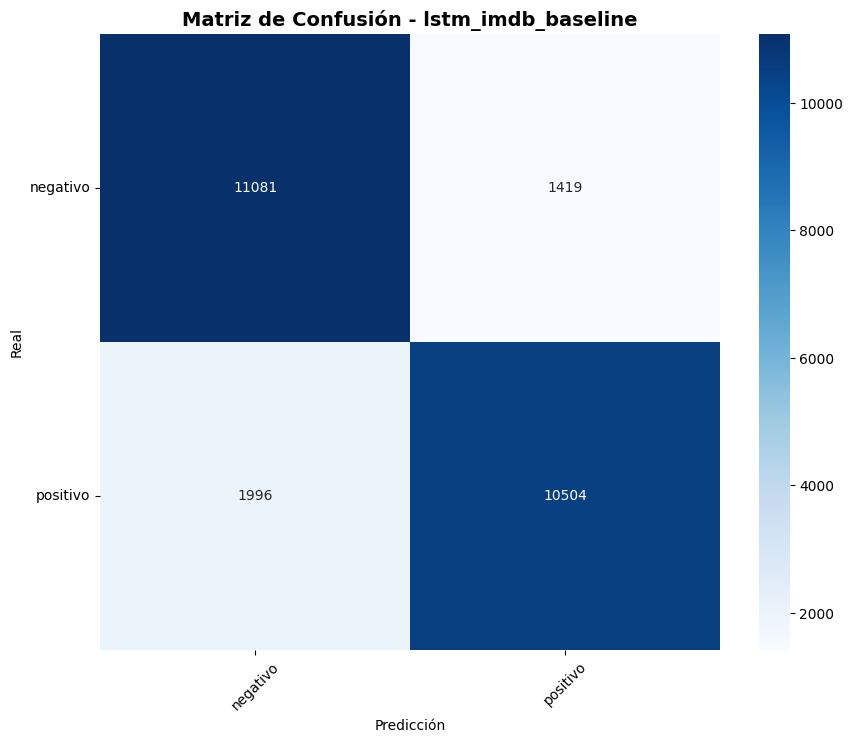

Matriz de confusión guardada en: ../results/2_lstm_text_imdb/confusion_matrix.png


array([[11081,  1419],
       [ 1996, 10504]])

In [ ]:
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    class_names=data.get_class_names(),
    notebook_name=NOTEBOOK_NAME,
    model_name=MODEL_NAME
)
probs = trainer.predict_proba(x_test)
conf = np.abs(probs - 0.5) * 2

correct = np.where(y_pred == y_test)[0]
wrong   = np.where(y_pred != y_test)[0]

good_idx = correct[np.argsort(-conf[correct])[:5]]
bad_idx  = wrong[np.argsort(conf[wrong])[:5]]

def show_examples(idx_list, title):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    for i in idx_list:
        txt = (data.decode_review(x_test[i]) if hasattr(data, "decode_review") else str(x_test[i]))[:800]
        print(f"[i={i}] true={y_test[i]} | pred={y_pred[i]} | proba={probs[i]:.3f}")
        print(txt + ("..." if len(txt) >= 800 else ""))
        print("-"*80)

show_examples(good_idx, "EJEMPLOS BUENOS (alta confianza & correctos)")
show_examples(bad_idx,  "EJEMPLOS MALOS (baja confianza & incorrectos)")


## 6) Ejemplos "buenos" y "malos" (texto decodificado)

In [ ]:
# %% [cm]
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    class_names=data.get_class_names(),
    notebook_name=NOTEBOOK_NAME,
    model_name=MODEL_NAME
)


1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

EJEMPLOS BUENOS (alta confianza, clasificación correcta)
[i=1] true=positivo | pred=positivo | conf=1.000
psychological trickery it's very interesting that robert altman directed this considering the style and structure of his other films still the trademark altman audio style is evident here and there i think what really makes this film work is the brilliant performance by sandy dennis it's definitely one of her darker characters but she plays it so perfectly and convincingly that it's scary michael burns does a good job as the mute young man regular altman player michael murphy has a small part the <UNK> moody set fits the content of the story very well in short this movie is a powerful study of loneliness sexual repression and desperation be patient <UNK> up the atmosphere and pay attention to the wonderfully written script br br i praise robert altman this is one of his many films that dea...
----------------------------------------

In [ ]:
# %% [examples]
probs = trainer.predict_proba(x_test)
conf = np.abs(probs - 0.5) * 2

correct = np.where(y_pred == y_test)[0]
wrong   = np.where(y_pred != y_test)[0]

good_idx = correct[np.argsort(-conf[correct])[:5]]
bad_idx  = wrong[np.argsort(conf[wrong])[:5]]

def show_examples(idx_list, title):
    print("\n" + "="*80)
    print(title)
    print("="*80)
    for i in idx_list:
        txt = (data.decode_review(x_test[i]) if hasattr(data, "decode_review") else str(x_test[i]))[:800]
        print(f"[i={i}] true={y_test[i]} | pred={y_pred[i]} | proba={probs[i]:.3f}")
        print(txt + ("..." if len(txt) >= 800 else ""))
        print("-"*80)

show_examples(good_idx, "EJEMPLOS BUENOS (alta confianza & correctos)")
show_examples(bad_idx,  "EJEMPLOS MALOS (baja confianza & incorrectos)")



---
### Notas
- **Métricas**: accuracy, loss y F1 quedan tabularizadas en `results/summary.csv` junto con tus otros modelos.
- **Curvas**: `learning_curves.png` en `results/2_lstm_text_imdb/`.
- **Matriz de confusión**: `confusion_matrix.png` en `results/2_lstm_text_imdb/`.
- **Ejemplos**: impresos en el notebook (con texto decodificado).
- Para **comparación** con tus otros ejercicios, abrí `results/summary.csv`.
